# Analysis

In [1]:
import glob
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from skimage import io

# import functions.py as module
import functions as fct

## Task 13: Plot Sample Image and Image Grid

### 13.1: Plot one image

c:\Users\s404923\AppData\Local\miniforge3\envs\MyEnv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


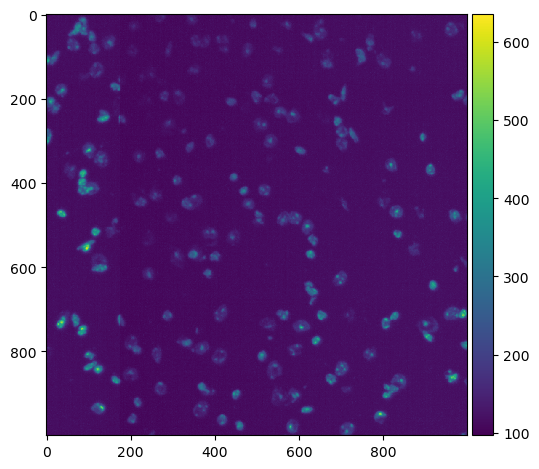

In [2]:
# plot sample image
samplefile = "../data/selected-tiles/selected-tiles/out_opt_flow_registered_X10_Y10_c01_DAPI.tif"
sampleimg = io.imread(samplefile)
io.imshow(sampleimg)

### 13.2: Create a list of files

In [3]:
# create list of all images with 'X10_Y10'
imglist = []
searchpattern = "../data/selected-tiles/selected-tiles/out_opt_flow_registered_X10_Y10_*.tif"
for file in glob.glob(searchpattern):
    imglist.append(file)
print('Number of files found: ' + str(len(imglist)))

Number of files found: 24


### 13.3: Plot a grid of images

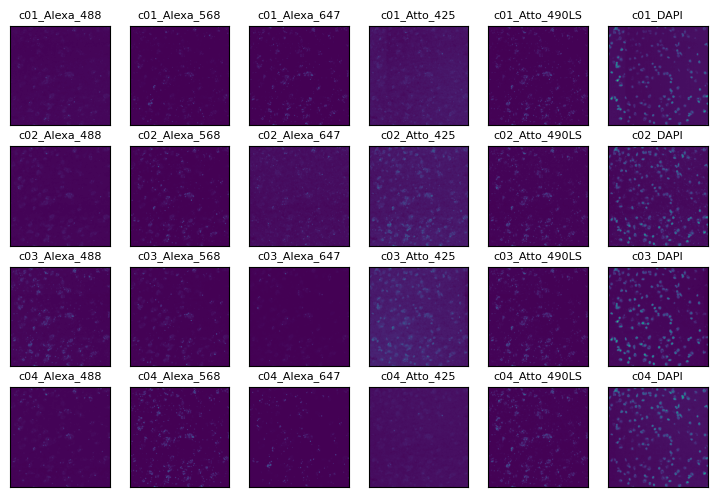

In [4]:
# plot images in imglist
img = io.imread_collection(imglist)
_, axs = plt.subplots(4, 6, figsize=(9, 6))

with plt.rc_context({'axes.titlesize': 8}): # change title font size
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(img[i])
        ax.set_xticks([])                   # remove x and y ticks
        ax.set_yticks([])
        title = os.path.basename(imglist[i]).removeprefix('out_opt_flow_registered_X10_Y10_').removesuffix('.tif')
        ax.set_title(title)                 # add filename in title
    plt.show()

## Task 14: Count Nuclei

***Which channel(s) is/are most promising for nucleus segmentation?*** <br>
DAPI stains entire nucleus and is expected to be most useful for segmentation of nuclei

***Which methods can you use, to distinguish between nucleus and the rest?*** <br>
Segmentation by intensity threshold or Machine Learning-based segmentation

***How can you devide the nuclei into separate instances?*** <br>
Blob Detection via local maxima or watershedding the segmented image

***Which problems occur, how can they be addressed?***
1) Gaussian Blur and counting local maxima alone do not work: many false positive counts in background
    - Possible solution: segmentation instead of counting local maxima
2) Segmentation works better, seemingly no false positive counts in background
    - But: some nuclei with non-homogeneous intensity are recognized as multiple small nuclei
        - Gaussian blur to avoid non-homogeneous intensity in nuclei
    - Additionally, some nuclei with low intensity are not recognized
        - Improved by adjusting the contrast
        - Triangle segmentation was found to work better than otsu
    - Removed small objects under a certain number of pixels from segmented image to avoid artifacts
3) Touching nuclei are counted as one
    - Watershed to split groups of nuclei
4) Some touching nuclei are not split in correct position, but into correct number of nuclei
    - This is left as is for now, as it does not seem to cause problems. might have to be fixed later on
5) Bigger groups of nuclei are not correctly split into single nuclei (mostly at and near the borders of the hemisphere)
    - Improved but not entirely fixed by finetuning the minimum distance of markers 
    - Somewhat improved by morphological opening on segmented image 
    - Small labels are removed by moving the `remove_small_objects()` function to after the watershed
    - Some groups of nuclei can still not be split correctly
6) Some fovs are not being segmented properly, due to hard edge in the background 
    - Improved for some fovs by background subtraction (leaving large artifacts) and combined removal of large objects. This is much more time-intensive (5.5 min vs. 2 min)
    - Some large nuclei are removed, while some smaller artifacts persist

### 14.1: Develop method on a single fov

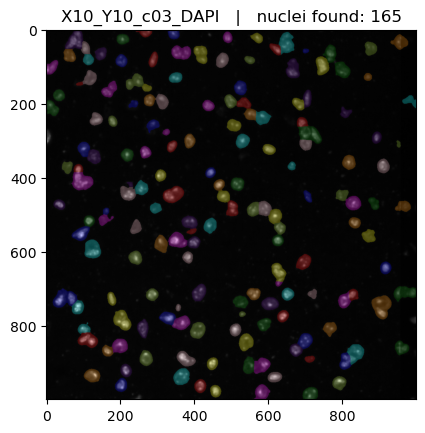

Number of nuclei found: 165


In [5]:
# use 'count_nuclei_v3()' function here
# arguments:    'image' should be the filepath to the desired image
#               'save=False' suppressed saving of diagnostic figure
#               'showplots=False' suppresses showing of diagnostic figure when running the function in Jupyter Notebook

nnuclei = fct.count_nuclei_v3('../data/selected-tiles/selected-tiles/out_opt_flow_registered_X10_Y10_c03_DAPI.tif')

print('Number of nuclei found: ' + str(nnuclei))

### 14.2: Run your method on all fovs

In [7]:
# use 'batch_count_nuclei()' here
# arguments:    'images' should be a list that contains all desired filenames
# 'batch_count_nuclei()' does not show diagnostic figures, but saves them into '../results/Task-14/'
# some of the files are overwritten, while some are not, so make sure the 'Task-14' is empty or does not exist

# create list of images
images = []
searchpattern = '../data/selected-tiles/selected-tiles/out_opt_flow_registered_*_c03_DAPI.tif'  # cycle number can also be changed, might change results slightly
for file in glob.glob(searchpattern):
    images.append(file)
print('Number of files found: ' + str(len(images)))

fct.batch_count_nuclei(images)

# takes about 5-6 min.

Number of files found: 190


,files,nucleus counts
0,X10_Y10_c03_DAPI,165
1,X10_Y11_c03_DAPI,196
2,X10_Y12_c03_DAPI,240
3,X10_Y13_c03_DAPI,233
4,X10_Y14_c03_DAPI,196
...,...,...
185,X23_Y4_c03_DAPI,144
186,X23_Y5_c03_DAPI,31
187,X23_Y6_c03_DAPI,45
188,X23_Y7_c03_DAPI,37


## Task 15: Identify transcripts

***How to perform spot detection and barcode decoding?*** <br>
- First approach: segment all channels individually, then in each round check each sequencing channel if nucleus (as defined by DAPI segmentation) contains segmented expression of the dye
    - Problem: multiple points of expression within a single nucleus, and sometimes points of expression outside of nuclei, so this approach does not work
- Second approach: merge sequencing channels and segment to use as mask
    - merging all sequencing channels of only first cycle works a little bit better than merging all cycles

***Which problems occur, how can they be addressed?*** <br>
1) Processing that worked for DAPI images in Task 14 does not work well for Alexa and Atto dyes
    - Different thresholding methods and preprocessing steps were tried out, but did not lead to reliably good results
    - Improved by contour segmentation
    - Performance of 'smaller' steps, like `ski.morphology.closing()` versus `ski.morphology.opening()` or values for some arguments was compared using the number of genes found, assuming that the increased number of genes found is the only important result, other than a generally acceptable diagnostic figure.
2) In some images (mostly Atto dyes), signal and background noise are hard to distinguish. this either leads to (apparent) nuclei with low intensity not being captured, or to multiple nuclei being captured as one and watershed not splitting them correctly due to background fluorescence between them
    - Differenciated segmentation workflow for Atto vs non-Atto dyes
3) Often, `check_expression()` recognizes the same nucleotide multiple times in the same label and cycle
    - Prevented by checking if this nucleotide was already recognized before adding it to `results`
4) Groups of nuclei in sequencing channels are sometimes not split correctly
    - This is not a problem, considering that the labels of the sequencing channels are not used in `check_expression()`.

***How could complications be solved?***
- In cases where no channels show intensity in the same cycle:
    - The most likely barcode could be approximated by comparing the identified barcode with known barcodes. E. g. if `AA0A` was found (with `0` being the missing nucleotide), we could postcode this pattern with the barcodes in the taglist. If only one barcode contains this pattern, the correct barcode could still be identified with high certainty.
    - If multiple barcodes contain this pattern, the possible missing nucleotides could be postcoded in their intensity in the corresponding area. For this, the mean intensity in the current mask could be normalized to the mean intensity of the entire image (to compensate for images with high background intensity). The nucleotide with the highest relative intensity is likely to be the correct nucleotide, but this method would be less reliable.
- In cases where multiple channels show intensity in the same cycle:
    - Again, the found barcode could be postcoded to the barcodes in the taglist. E. g. if `AA[TC]A` was found (with `[TC]` being the nucleotides found in the same cycle), we could check for `AATA` and `AACA` in the taglist. If only one of these barcodes exist, it is likely to be the correct barcode.
    - If multiple of the possible barcodes exist, we could again postcode the intensities.
    - Sometimes, multiple channels show intensity in the same cycle, indicating that some invalid barcodes are true to the dataset and are to be accepted.

### 15.1-2: Spot detection and barcode decoding on a single fov

In [8]:
# use 'decode_barcode()' on one fov here
# arguments:    'fov' is the name of the fov that should be
#               'subfolder' is the name of the subfolder that results are saved to
#                   some of the files are overwritten, while some are not, so make sure the subfolder is empty or does not exist

fov = 'X10_Y10'
subfolder = 'X10_Y10'

fct.decode_barcode(fov, subfolder)

# takes about 15-20 sec

,fov,x,y,barcode,gene
0,X10_Y10,8.500000,275.500000,0TGC,invalid
1,X10_Y10,8.923077,334.564103,TACG,Gapdh
2,X10_Y10,10.500000,637.285714,00CG,invalid
3,X10_Y10,12.500000,937.000000,0000,invalid
4,X10_Y10,14.146667,644.093333,GACC,Sstr1
...,...,...,...,...,...
597,X10_Y10,977.958333,730.770833,TACG,Gapdh
598,X10_Y10,982.812500,569.368056,TTCC,no match
599,X10_Y10,988.621622,580.243243,AAAC,Rprml
600,X10_Y10,990.546012,716.153374,GACG,no match


In [9]:
# use 'count_genes()'
# arguments:    'subfolder' is the name of the subfolder that contains the results from 'decode_barcode()'
#               'omit=True' omits all 'invalid' and 'no match' entries from the returned dataframe
#               'saveconcat=True' saves the concatenated dataframe that contains the results from 'decode_barcode()'
#                   if this is 'False', only the gene count dataframe is saved
fct.count_genes(subfolder='X10_Y10', omit=False, saveconcat=True)

,fov,gene,count
0,X10_Y10,invalid,361.0
1,X10_Y10,no match,83.0
2,X10_Y10,Gapdh,55.0
3,X10_Y10,Bcl11b,29.0
4,X10_Y10,Cux2,11.0
5,X10_Y10,Atp1a2,10.0
6,X10_Y10,Atp2b4,8.0
7,X10_Y10,Sstr1,6.0
8,X10_Y10,Spon1,6.0
9,X10_Y10,Rorb,4.0


### 15.4: Spot detection and barcode decoding on multiple fovs

- Any number of fovs of 36 or under can be processed from the cells below.
- Due to a weird MemoryError that occurs, longer fov lists may need to be processed using the `run_run.sh` script. Here is how to do it:
    1. Open bash or python terminal.
    2. `cd code` to set the current folder.
    3. `chmod +x run_run.sh` to give permission to run the script. This has to be done only once.
    4. `./run_run.sh` to execute the script.
        - Before running the script, the desired fovs and the subfolder can be set directly in the script.

In [11]:
# use 'decode_barcode()' on multiple fovs here
# !! lists with a length of over 36 may need to be run using 'run_run.sh'!!
# arguments:    'fov' is the name of the fov that should be
#               'subfolder' is the name of the subfolder that results are saved to

# define 'fov' list
fov = []                                # get all names of fovs
searchpattern = '../data/selected-tiles/selected-tiles/out_opt_flow_registered_*_c01_DAPI.tif'
for file in glob.glob(searchpattern):
    fovname = os.path.basename(file).removeprefix('out_opt_flow_registered_').removesuffix('_c01_DAPI.tif')
    fov.append(fovname)
fov = fov[:2]                           # specify, which fov(s) should be processed
print('Number of fovs to be processed: ' + str(len(fov)))

subfolder = 'multiple-fovs'             # name the subfolder the results will be saved into

# run 'decode_barcode()'
for i in range(0, len(fov)):
    print('Processing fov ' + str(i+1) + ' out of ' + str(len(fov)) + '...', end='\r')
    fct.decode_barcode(fov[i], subfolder)
print('Processing of all fovs completed.         ')

# takes about 40 sec for 2 fovs

Number of fovs to be processed: 2
Processing of all fovs completed.         


In [12]:
# use 'count_genes()'
# arguments:    'subfolder' is the name of the subfolder that contains the results from 'decode_barcode()'
#               'omit=True' omits all 'invalid' and 'no match' entries from the returned dataframe
#               'saveconcat=True' saves the concatenated dataframe that contains the results from 'decode_barcode()'
#                   if this is 'False', only the gene count dataframe is saved

fct.count_genes(subfolder='multiple-fovs', omit=False, saveconcat=True)

,fov,gene,count
0,X10_Y10,invalid,361.0
1,X10_Y10,no match,83.0
2,X10_Y10,Gapdh,55.0
3,X10_Y10,Bcl11b,29.0
4,X10_Y10,Cux2,11.0
5,X10_Y10,Atp1a2,10.0
6,X10_Y10,Atp2b4,8.0
7,X10_Y10,Sstr1,6.0
8,X10_Y10,Spon1,6.0
9,X10_Y10,Rorb,4.0


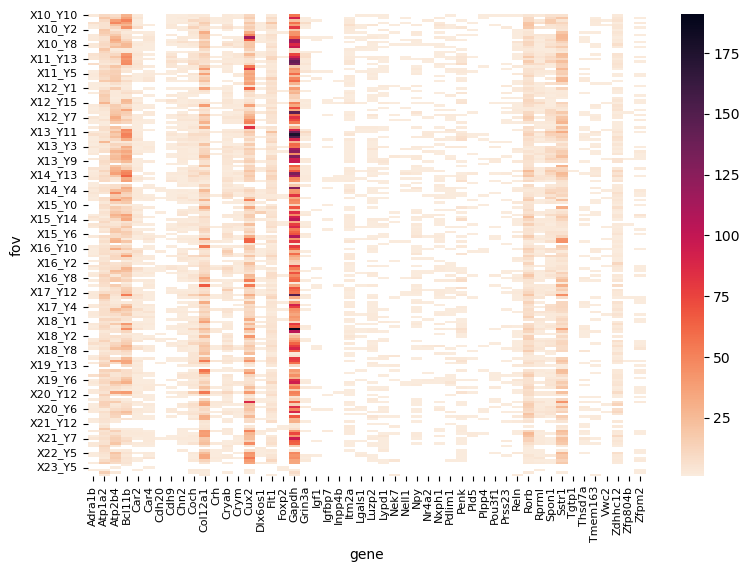

In [17]:
# plot 'gene-counts.csv' as heatmap

subfolder = 'all-fovs'

df = pd.read_csv('../results/Task-15/' + subfolder + '/gene-counts.csv')
df = df[df['gene'] != 'invalid']
df = df[df['gene'] != 'no match']
df = df.pivot(index='fov', columns='gene', values='count')
fig, ax = plt.subplots(figsize=(9, 6))
plot = sns.heatmap(ax=ax, data=df, cmap='rocket_r', xticklabels=1)
fig = plot.get_figure()
plt.tick_params(axis='both', labelsize=8)
fig.savefig('../results/Task-15/' + subfolder + '/gene-counts_heatmap.png', bbox_inches='tight')

### 15.3: Visualize results in napari

In [18]:
# use 'visualize()'
# arguments:    'fov' is the name of the fov that should be displayed
#               'subfolder' is the name of the subfolder where the results tables are
#               'markers' decides how the identified points should be marked
#                   'markers='shapes'' marks the points with polygon outlines
#                   'markers='points'' marks the points with points at their centroid position
#               'labelonlygenes=True' only displays text labels for identified genes and omits labels for 'invalid' and 'no match' results

fct.visualize(fov='X10_Y10', subfolder='all-fovs', labelonlygenes=True)

Viewer(camera=Camera(center=(0.0, 499.5, 499.5), zoom=0.24082499999999998, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=0.0, stop=3.0, step=1.0), RangeTuple(start=0.0, stop=999.0, step=1.0), RangeTuple(start=0.0, stop=999.0, step=1.0)), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(1.0, 499.0, 499.0), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'C' at 0x1f9f59a5fd0>, <Image layer 'G' at 0x1f9d8fcc750>, <Image layer 'T' at 0x1f9fbad5ad0>, <Image layer 'A' at 0x1fa16859ad0>, <Image layer 'DAPI' at 0x1f991893490>, <Shapes layer 'Outlines' at 0x1fa0ffb1690>, <Shapes layer 'Outlines-Text' at 0x1fa100f1e50>], help='use <7> for transform, use <R> for add rectangle

### 15.5: Compare your results with other methods

#### Comparison of numbers

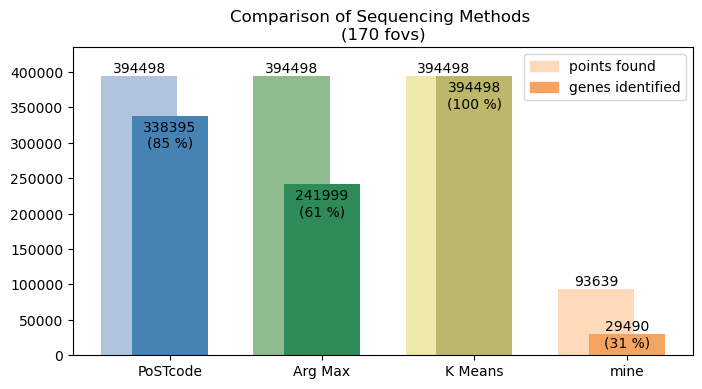

In [20]:
# get data to compare
postcodefile    = '../data/decoding/decoding/NT_ISS_KR0018_PoSTcode.csv'
postcodedf      = pd.read_csv(postcodefile)
argmaxfile      = '../data/decoding/decoding/NT_ISS_KR0018_argmax.csv'
argmaxdf        = pd.read_csv(argmaxfile)
kmeansfile      = '../data/decoding/decoding/NT_ISS_KR0018_kmeans.csv'
kmeansdf        = pd.read_csv(kmeansfile)
myfile          = '../results/Task-15/all-fovs/concatenated-results.csv'
mydf            = pd.read_csv(myfile)

# get barcode and gene counts of PoSTcode sequencing
df = postcodedf.groupby(['Tile']).count()                    # get barcode counts
df = df['Name']
df.name = 'barcodes'

postcodedf = postcodedf[postcodedf['Name'] != 'infeasible']    # remove invalid counts to get gene counts
postcodedf = postcodedf[postcodedf['Name'] != 'background']
temp = postcodedf.groupby(['Tile']).count()
temp = temp['Name']
temp.name = 'genes'

df = pd.DataFrame([df, temp]).T

# get barcode and gene counts of ArgMax sequencing
temp = argmaxdf.groupby(['Tile']).count()                        # get barcode counts
temp = temp['Name']
temp.name = 'barcodes'
df = pd.concat([df, temp], axis=1)

argmaxdf = argmaxdf[argmaxdf['Name'] != 'infeasible']
argmaxdf = argmaxdf[argmaxdf['Name'] != 'background']
temp = argmaxdf.groupby(['Tile']).count()
temp = temp['Name']
temp.name = 'genes'
df = pd.concat([df, temp], axis=1)

# get barcode and gene counts of KMeans sequencing
temp = kmeansdf.groupby(['Tile']).count()                        # get barcode counts
temp = temp['Name']
temp.name = 'barcodes'
df = pd.concat([df, temp], axis=1)

kmeansdf = kmeansdf[kmeansdf['Name'] != 'infeasible']
kmeansdf = kmeansdf[kmeansdf['Name'] != 'background']
temp = kmeansdf.groupby(['Tile']).count()
temp = temp['Name']
temp.name = 'genes'
df = pd.concat([df, temp], axis=1)

# get barcode and gene counts of my sequencing
temp = mydf.groupby(['fov']).count()                        # get barcode counts
temp = temp['gene']
temp.name = 'barcodes'
df = pd.concat([df, temp], axis=1)

mydf = mydf[mydf['gene'] != 'invalid']
mydf = mydf[mydf['gene'] != 'no match']
temp = mydf.groupby(['fov']).count()
temp = temp['gene']
temp.name = 'genes'
df = pd.concat([df, temp], axis=1)

# formatting dataframe
multiindex = pd.MultiIndex.from_tuples(                     # make two-level columnnames
    [
        ('PoSTcode', df.columns[0]),
        ('PoSTcode', df.columns[1]),
        ('Arg Max', df.columns[2]),
        ('Arg Max', df.columns[3]),
        ('K Means', df.columns[4]),
        ('K Means', df.columns[5]),
        ('mine', df.columns[6]),
        ('mine', df.columns[7])
    ],
    names=('method', 'count')
)
df.columns = multiindex
df.sort_index()

df = df.dropna()                                            # keep only fovs where all methods have results

#df.to_csv('../results/Task-15/test-comparison.csv')

# display as bar plot
results = []
for i in range(0, len(df.columns)):
    temp = df[df.columns[i]].sum()
    results.append(temp)

_, ax = plt.subplots(figsize=(8, 4))
bar = ax.bar(
    x           = [0, 0.2, 1, 1.2, 2, 2.2, 3, 3.2],
    height      = results,
    color       = [
        'lightsteelblue', 'steelblue',
        'darkseagreen', 'seagreen',
        'palegoldenrod', 'darkkhaki',
        'peachpuff', 'sandybrown'
    ],
    tick_label  = ('', 'PoSTcode', '', 'Arg Max', '', 'K Means', '', 'mine'),
    width       = 0.5
)
ax.set_xticks([0.2, 1.2, 2.2, 3.2])
labels = ax.bar_label(bar, label_type='edge')
for i in range(0, len(labels)):
    if i % 2:
        labels[i].set_position((labels[i].get_position()[0], labels[i].get_position()[1]-25))
        labels[i].set_text(str(int(results[i])) + '\n(' + str(int(results[i]/results[i-1]*100)) + ' %)')
labels[7].set_position((labels[7].get_position()[0], labels[7].get_position()[1]+14))
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax*1.05)

plt.title('Comparison of Sequencing Methods \n('+str(df['PoSTcode']['barcodes'].count())+' fovs)')

plt.legend(
    handles = [
        mpatches.Patch(color='peachpuff', label='points found'), 
        mpatches.Patch(color='sandybrown', label='genes identified')]
)

plt.savefig('../results/Task-15/' + subfolder + '/comparison-barplot.png', bbox_inches='tight')

#### Visual Comparison

In [22]:
# use 'visualize()'
fov = 'X10_Y2'  # when changing the fov, the point coordinates need to be changed too!
comparefile = '../data/decoding/decoding/NT_ISS_KR0018_PoSTcode.csv'    # can be changed to compare another method
viewer = fct.visualize(fov=fov, subfolder='all-fovs', labelonlygenes=True)

# add annotations for PoSTcode segmentation results
barcodes = pd.read_csv(comparefile, usecols=['Code', 'Name', 'Tile'])
barcodes = barcodes[barcodes['Tile'] == str(fov)]
del barcodes['Tile']
barcodes = barcodes.reset_index(drop=True)

textlabels = []
for i in range(0, barcodes['Name'].count()):                            # display text only for identified genes
    if barcodes['Name'][i] != 'infeasible' and barcodes['Name'][i] != 'background':
        textlabels.append(barcodes['Code'][i] + ':\n' + barcodes['Name'][i])
    else: 
        textlabels.append('')
features = {'textlabels': textlabels}
text = {
    'string': '{textlabels}',
    'size': 5,
    'color': 'steelblue',
    'translation': np.array([-1, 0]),
    'anchor': 'upper_left'
}

points = pd.read_csv(comparefile, usecols=['X', 'Y', 'Tile'])
points = points[points['Tile'] == str(fov)]
del points['Tile']
points = points.reset_index(drop=True)
points['Y'] = points['Y']-2000
points = points[['Y', 'X']]
points.columns = ['x', 'y']
viewer.add_points(points, symbol='cross', size=1.2, border_width=0, face_color='steelblue', features=features, text=text, name='PoSTcode')

viewer.layers['DAPI'].visible = False

c:\Users\s404923\AppData\Local\miniforge3\envs\MyEnv\Lib\site-packages\napari\layers\shapes\_shapes_utils.py:765: RuntimeWarning: overflow encountered in square
  miter_lengths_squared = (miters**2).sum(axis=1)
c:\Users\s404923\AppData\Local\miniforge3\envs\MyEnv\Lib\site-packages\napari\layers\shapes\_shapes_utils.py:682: RuntimeWarning: invalid value encountered in cast
  y = np.sign(x).astype(int)


- The other sequencing methods yield a much higher number of points and identified genes, as seen in the bar plot.
- Visual comparison in Napari: (comparison of X10_Y2 with PoSTcode)
    - PoSTcode yields better results at groups of close-by points, where my method cannot split the points correctly.
    - PoSTcode is able to correctly identify many of the 'invalid' or 'no match' points of my method.
    - PoSTcode recognizes many more points than my method, partly due to the correct splitting of groups of points, but also due to a high number of points, that are not recognized by my method. 
    - Some of these points are identified correctly, while some can not be attributed to points of fluorescence that are visible by eye. These points might be false positives. This is supported by lots of these points identifying `A`s in regions with high background fluorescence.
- Critiques and possible points of improvement of my method:
    - Segmentation needs to be improved to ideally capture all of the points of fluorescence that are seen by eye. This could be done by including additional preprocessing steps or changing the thresholding method.
    - `check_expression()` needs to be improved, as it is too restrictive and does not recognize a complete barcode for most of the points. This could be done by trying to change the segmentation steps for the sequencing channels. Alternatively, it might be beneficial to change the method to indentify the nucleotides all together. Directly measuring and comparing the intensities of the sequencing channels could lead to better results.